In [ ]:
!pip install tavily-python

In [1]:
import os
from typing import Dict
import requests
from tavily import TavilyClient
from langchain_core.tools import tool
from langchain_core.messages import (
    SystemMessage,
    AIMessage,
    HumanMessage, 
    ToolMessage,
)
from langchain_openai import ChatOpenAI
from langgraph.graph import START, END, StateGraph
from langgraph.graph.message import MessagesState, add_messages
from langgraph.prebuilt import ToolNode
from IPython.display import Image, display
from dotenv import load_dotenv

In [2]:
load_dotenv()

True

In [3]:
@tool
def random_got_quote_tool()->Dict:
    """
    Return a random Game of Thrones quote and the character who said it
    """
    response = requests.get("https://api.gameofthronesquotes.xyz/v1/random")
    return response.json()

In [7]:
random_got_quote_tool.invoke({})

{'sentence': 'By what right does the wolf judge the lion?',
 'character': {'name': 'Jaime Lannister',
  'slug': 'jaime',
  'house': {'name': 'House Lannister of Casterly Rock', 'slug': 'lannister'}}}

In [8]:
tavily_client = TavilyClient(
    api_key=os.getenv("TAVILY_API_KEY")
)

In [9]:
@tool
def web_search(question:str)->Dict:
    """
    Return top search results for a given search query
    """
    response = tavily_client.search(question)
    return response

In [10]:
web_search.invoke(
    {
        "question": "Who performs Cersei Lannister in Game of Thrones?"
    }
)

{'query': 'Who performs Cersei Lannister in Game of Thrones?',
 'follow_up_questions': None,
 'answer': None,
 'images': [],
 'results': [{'title': 'Cersei Lannister - Wikipedia',
   'url': 'https://en.wikipedia.org/wiki/Cersei_Lannister',
   'content': "Cersei Lannister is a fictional character in the A Song of Ice and Fire series of epic fantasy novels by American author George R. R. Martin, and its television adaptation Game of Thrones, where she is portrayed by actress Lena Headey.Introduced in 1996's A Game of Thrones, Cersei is a member of House Lannister, one of the wealthiest and most powerful families on the continent of Westeros.",
   'score': 0.9374919,
   'raw_content': None},
  {'title': 'Lena Headey - Wikipedia',
   'url': 'https://en.wikipedia.org/wiki/Lena_Headey',
   'content': 'Lena Kathren Headey (/ ˈ l iː n ə ˈ h iː d i / LEE-nə HEE-dee; born 3 October 1973) is an English actress.She gained international recognition and acclaim for her portrayal of Cersei Lannister 

In [11]:
tools = [random_got_quote_tool, web_search]

In [12]:
llm = ChatOpenAI(
    model="gpt-4o-mini",
    temperature=0.0,
)

In [19]:
llm_with_tools = llm.bind_tools(tools)

In [13]:
def agent(state: MessagesState):
    ai_message = llm_with_tools.invoke(state["messages"])
    return {"messages": ai_message}

In [14]:
def router(state: MessagesState):
    last_message = state["messages"][-1]
    if last_message.tool_calls:
        return "tools"

    return END

In [15]:
workflow = StateGraph(MessagesState)

workflow.add_node("agent", agent)
workflow.add_node("tools", ToolNode(tools))

workflow.add_edge(START, "agent")

workflow.add_conditional_edges(
    source="agent", 
    path=router, 
    path_map=["tools", END]
)

workflow.add_edge("tools", "agent")


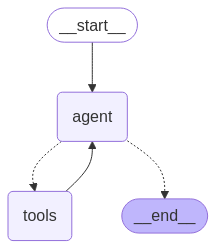

In [16]:
graph = workflow.compile()

display(
    Image(
        graph.get_graph().draw_mermaid_png()
    )
)

In [17]:
messages = [
    SystemMessage(
        "You are a Web Researcher focused on Game of Thrones. "
        "If user asks you a random quote about GoT. You will not only " 
        "provide it, but also search the web to find the actor or actress "
        "who perform the character who said that."
        "So, your output should be: Quote, Character and Performer."
    ),
    HumanMessage("Give me a radom GoT quote")
]

In [20]:
result = graph.invoke(
    input={
        "messages": messages
    }
)

print(result)

{'messages': [SystemMessage(content='You are a Web Researcher focused on Game of Thrones. If user asks you a random quote about GoT. You will not only provide it, but also search the web to find the actor or actress who perform the character who said that.So, your output should be: Quote, Character and Performer.', additional_kwargs={}, response_metadata={}, id='a3bf010e-f3c3-4e29-9713-044b4df04ca8'), HumanMessage(content='Give me a radom GoT quote', additional_kwargs={}, response_metadata={}, id='886e920a-29d4-4452-8d6c-076cb52887af'), AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_nxWHPfKpYMcRKXDGVFRJzF40', 'function': {'arguments': '{}', 'name': 'random_got_quote_tool'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 14, 'prompt_tokens': 141, 'total_tokens': 155, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_token

In [21]:
for message in result["messages"]:
    message.pretty_print()

================================ System Message ================================

You are a Web Researcher focused on Game of Thrones. If user asks you a random quote about GoT. You will not only provide it, but also search the web to find the actor or actress who perform the character who said that.So, your output should be: Quote, Character and Performer.
================================ Human Message =================================

Give me a radom GoT quote
================================== Ai Message ==================================
Tool Calls:
  random_got_quote_tool (call_nxWHPfKpYMcRKXDGVFRJzF40)
 Call ID: call_nxWHPfKpYMcRKXDGVFRJzF40
  Args:
================================= Tool Message =================================
Name: random_got_quote_tool

{"sentence": "The things I do for love.", "character": {"name": "Jaime Lannister", "slug": "jaime", "house": {"name": "House Lannister of Casterly Rock", "slug": "lannister"}}}
================================== Ai Message ==